# Cycle counting method for liquefaction assessment during the 4th September 2010 Darfield earthquake

In [2]:
# import packages
import eqsig
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import helpers
import glob


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Load the recorded ground motion

Text(0, 0.5, 'Acc (Comp. 2) [$m/s^2$]')

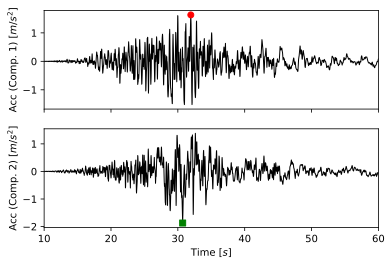

In [7]:
eq = '2010Sept04'
station = 'SHLC'
rec_ffps = glob.glob(helpers.ROOT_DIR + "{0}/*{1}*.csv".format(eq, station))
if not len(rec_ffps):  # If not downloaded then download from geonet
    helpers.download_motion(station)
    rec_ffps = glob.glob(helpers.ROOT_DIR + "{0}/*{1}*.csv".format(eq, station))
    
# Get the ground motion from the database
acc_values1, acc_values2, acc_vert, dt = helpers.load_nz_motions_3comp_v2(rec_ffps[0])
asig1 = eqsig.AccSignal(acc_values1, dt)
asig2 = eqsig.AccSignal(acc_values2, dt)

bf, sps = plt.subplots(nrows=2, sharex=True)
sps[0].plot(asig1.time, asig1.values, c='k', lw=1)
sps[1].plot(asig2.time, asig2.values, c='k', lw=1)
ind_pga_1 = np.argmin(np.abs(np.abs(asig1.values) - asig1.pga))
ind_pga_2 = np.argmin(np.abs(np.abs(asig2.values) - asig2.pga))
sps[0].plot(asig1.time[ind_pga_1], asig1.values[ind_pga_1], 'o', c='r')
sps[1].plot(asig2.time[ind_pga_2], asig2.values[ind_pga_2], 's', c='g')
sps[0].set_xlim(10, 60)
sps[-1].set_xlabel('Time [$s$]')
sps[0].set_ylabel('Acc (Comp. 1) [$m/s^2$]')
sps[1].set_ylabel('Acc (Comp. 2) [$m/s^2$]')

## Plot bi-directional motion

PGA_1: 0.167g
PGA_2: 0.191g
PGA_gm: 0.178g


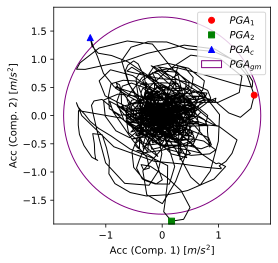

In [15]:
acc_c = np.sqrt(asig1.values ** 2 + asig2.values ** 2)
pga_c = np.max(np.abs(acc_c))
ind_pga_c = np.argmin(np.abs(acc_c - pga_c))
bf, ax = plt.subplots()
ax.plot(asig1.values, asig2.values, lw=1, c='k')
ax.plot(asig1.values[ind_pga_1], asig2.values[ind_pga_1], 'o', c='r', label='$PGA_1$')
ax.plot(asig1.values[ind_pga_2], asig2.values[ind_pga_2], 's', c='g', label='$PGA_2$')
ax.plot(asig1.values[ind_pga_c], asig2.values[ind_pga_c], '^', c='b', label='$PGA_c$')
pga_gm = np.sqrt(asig1.pga * asig2.pga)
circle1 = plt.Circle((0, 0), pga_gm, color='purple', fill=False, label='$PGA_{gm}$')
ax.add_artist(circle1)
ax.set_xlim([-pga_gm * 1.1, pga_gm * 1.1])
ax.set_ylim([-pga_gm * 1.1, pga_gm * 1.1])
ax.set_aspect('equal')

handles, labels = ax.get_legend_handles_labels()
handles.append(circle1)
ax.set_xlabel('Acc (Comp. 1) [$m/s^2$]')
ax.set_ylabel('Acc (Comp. 2) [$m/s^2$]')
plt.legend(handles=handles)
print('PGA_1: %.3fg' % (asig1.pga / 9.8))
print('PGA_2: %.3fg' % (asig2.pga / 9.8))
print('PGA_gm: %.3fg' % (pga_gm / 9.8))

## Compute $n_{cycles}$ from time series for $0.65PGA_{gm}$ 
Algorithm is based on the Seed (1975) algorithm, features:
 - based on the P-M fatigue hypothesis (no degradation considered)
 - Uses a power law weighting function
 
 $$CSR = a \cdot n_{cycles}^{-b}$$
 
 - Computes orthogonal recorded components of a motion and takes geometric mean
 - Considers peaks as the maximum between each zero crossing
 
Algorithm sums all peaks, where $CSR_{ref}$ is typically taken as 0.65 of the maximum value: 
(See also Kishida et al (2014) Eq. 4)
 
 $$n_{cycles} = 0.5 \sum_{j=1}^n\left(\frac{CSR_{j}}{CSR_{ref}}\right)^{(1/b)}$$

### Define function for computing number of cycles and test

In [17]:
def calc_n_eq_sbm(csr_values, csr_ref, b, cut_off=0.01):
    peak_indices = eqsig.get_switched_peak_array_indices(csr_values)
    csr_peaks = np.abs(np.take(csr_values, peak_indices))
    csr_peaks = np.where(csr_peaks < cut_off * np.max(abs(csr_values)), 1.0e-14, csr_peaks)
    n_ref = 1
    perc = 0.5 / (n_ref * (csr_ref / csr_peaks) ** (1 / b))
    n_eq = np.cumsum(perc)
    n_eq = np.insert(n_eq, 0, 0)
    peak_indices = np.insert(peak_indices, 0, 0)
    n_eq = np.insert(n_eq, len(n_eq)-1, n_eq[-1])
    peak_indices = np.insert(peak_indices, len(n_eq)-1, len(csr_values))

    f = scipy.interpolate.interp1d(peak_indices, n_eq, kind='previous')
    n_series = f(np.arange(len(csr_values)))
    return n_series

### Test for sine wave of 15 cycles

In [18]:
n_sine_n15 = calc_n_eq_sbm(np.sin(np.linspace(0, 30 * np.pi, 30 * 20)), csr_ref=1.0, b=0.34)[-1]
print('n_sine_n15: %.1f == 15' % n_sine_n15)

n_sine_n15: 15.0 == 15


### Apply to each component of recorded motion

n_cycles (1, 2): (18.8, 13.8)
n_cycles_gm: 16.1


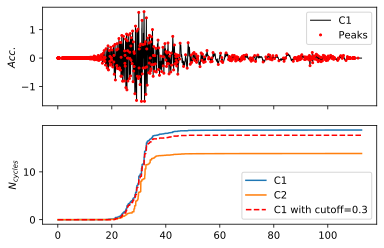

In [21]:
n_series_1 = calc_n_eq_sbm(asig1.values, 0.65 * pga_gm, b=0.34)
n_series_1_w_cutoff = calc_n_eq_sbm(asig1.values, 0.65 * pga_gm, b=0.34, cut_off=0.3)
n_series_2 = calc_n_eq_sbm(asig2.values, 0.65 * pga_gm, b=0.34)
bf, sps = plt.subplots(nrows=2, sharex=True)
peak_indices = eqsig.get_switched_peak_array_indices(asig1.values)
sps[0].plot(asig1.time, asig1.values, label='C1', c='k', lw=1)
sps[0].plot(asig1.time[peak_indices], asig1.values[peak_indices], 'o', c='r', label='Peaks', ms=2)
sps[1].plot(asig1.time, n_series_1, label='C1')
sps[1].plot(asig1.time, n_series_2, label='C2')
sps[1].plot(asig1.time, n_series_1_w_cutoff, ls='--', c='r', label='C1 with cutoff=0.3')
sps[0].set_ylabel('$Acc.$')
sps[1].set_ylabel('$N_{cycles}$')
sps[0].legend()
sps[1].legend()
print('n_cycles (1, 2): (%.1f, %.1f)' % (n_series_1[-1], n_series_2[-1]))
n_cycs = np.sqrt(n_series_1[-1] * n_series_2[-1])
print('n_cycles_gm: %.1f' % n_cycs)

## Compute the equivalent $CSR_{ncyc}$ from the time series

Inversion of $n_{cycles}$ formula: (See Kishida et al (2014) Eq. 8)

$$CSR_{ncyc} = \left(\frac{0.5}{n_{cycles}}\sum_{j=1}^n CSR_j ^ {(1/b)}\right) ^ b$$

### Define a function

In [24]:
def calc_csr_ncyc_series(csr_values, n_cycles, b=0.34, cut_off=0.01):
    peak_indices = eqsig.get_switched_peak_array_indices(csr_values)
    csr_peaks = np.abs(np.take(csr_values, peak_indices))
    csr_peaks = np.where(csr_peaks < cut_off * np.max(abs(csr_values)), 1.0e-14, csr_peaks)

    csr_ncyc_at_peaks = np.cumsum((np.abs(csr_peaks) ** (1. / b)) / 2 / n_cycles) ** b
    csr_ncyc_at_peaks = np.insert(csr_ncyc_at_peaks, 0, 0)
    peak_indices = np.insert(peak_indices, 0, 0)
    csr_ncyc_at_peaks = np.insert(csr_ncyc_at_peaks, len(csr_ncyc_at_peaks)-1, csr_ncyc_at_peaks[-1])
    peak_indices = np.insert(peak_indices, len(csr_ncyc_at_peaks)-1, len(csr_values))

    f = scipy.interpolate.interp1d(peak_indices, csr_ncyc_at_peaks, kind='previous')
    csr_ncyc_series = f(np.arange(len(csr_values)))
    return csr_ncyc_series

### Check formulations are equivalent

In [25]:
csr_n15_series_1 = calc_csr_ncyc_series(asig1.values / 9.8, n_cycles=15, b=0.34)
csr_n15_series_2 = calc_csr_ncyc_series(asig2.values / 9.8, n_cycles=15, b=0.34)
n_series_1 = calc_n_eq_sbm(asig1.values / 9.8, csr_n15_series_1[-1], b=0.34)
n_series_2 = calc_n_eq_sbm(asig2.values / 9.8, csr_n15_series_2[-1], b=0.34)
print('n_cycles using calculated csr_n15: (1, 2): (%.4f, %.4f)' %(n_series_1[-1], n_series_2[-1]))

n_cycles using calculated csr_n15: (1, 2): (15.0000, 15.0000)


### Plot $CSR_{n15}$ for motion

csr_n15 (1, 2): (0.125, 0.113)
csr_n15_gm: 0.12


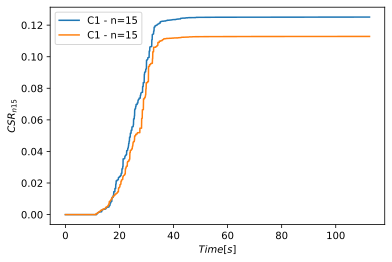

In [32]:
bf, sps = plt.subplots(nrows=1)
sps.plot(asig1.time, csr_n15_series_1, label='C1 - n=15')
sps.plot(asig1.time, csr_n15_series_2, label='C1 - n=15')
sps.set_ylabel('$CSR_{n15}$')
sps.set_xlabel('$Time [s]$')
plt.legend()
print('csr_n15 (1, 2): (%.3f, %.3f)' % (csr_n15_series_1[-1], csr_n15_series_2[-1]))
csr_n15_gm = np.sqrt(csr_n15_series_1[-1] * csr_n15_series_2[-1])
print('csr_n15_gm: %.2f' % csr_n15_gm)


## Investigate influence of b on $CSR_{n15}$ and $n_{cyc}$

### Vary b and compute $CSR_{n}$

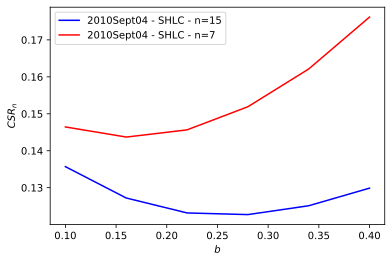

In [31]:
csr_df_n15 = []
csr_df_n7 = []
b_vals = np.linspace(0.1, 0.4, 6)
for b_val in b_vals:
    csr_df_n15.append(calc_csr_ncyc_series(asig1.values / 9.8, n_cycles=15, b=b_val)[-1])
    csr_df_n7.append(calc_csr_ncyc_series(asig1.values / 9.8, n_cycles=7, b=b_val)[-1])

bf, sps = plt.subplots()
sps.plot(b_vals, csr_df_n15, label='2010Sept04 - %s - n=15' % station, c='b')
sps.plot(b_vals, csr_df_n7, label='2010Sept04 - %s - n=7' % station, c='r')
sps.set_xlabel('$b$')
sps.set_ylabel('$CSR_{n}$')
plt.legend()